<a href="https://colab.research.google.com/github/ongsaraks/AICLUBHACKATHON/blob/main/example_classification_code_for_hackathon_aaa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon AAA starter code

The file `labeled_data.zip` consists of 2 folders.
- `train`
- `test`

All of the content in `train` can be used for train the model. It consists of image in the `img` folder and label in `dataset_info.csv`.

The content in `test` must be used for submit score only. There will be only image in the `img` folder but there won't be label.

The code below is an example of how to tackle the problem presented in hackathon.

By doing nothing and run every cell in this notebook, it should produce F1 score around 0.6 on test set. Your task is to improve the F1 score on test set.

There are hints scatter around the code below, most of them are what is generally works for most machine learning model.

In [ ]:
!unzip labeled_data.zip

Archive:  labeled_data.zip
replace labeled_data/test/class_labels.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
from time import perf_counter
import pandas as pd
import json
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision.transforms import v2 as transforms
from PIL import Image
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:

class BasicAAADataset(Dataset):
    def __init__(self, img_dir, dataset_info, num_classes) -> None:
        pil2tensor = transforms.PILToTensor()
        resize = transforms.Resize(224, antialias=False, interpolation=transforms.InterpolationMode.NEAREST)
        imgs = []
        labels = []
        for idx, row in dataset_info.iterrows():
            with Image.open(os.path.join(img_dir, row["img_name"])) as img_f:
                img = pil2tensor(img_f)
                img = resize(img) #  Hint: One can try random crop resize augmentation.
            label = torch.zeros((num_classes, ))
            for cls_name, cls_idx in class_labels.items():
                if row[cls_name] == 1:
                    label[cls_idx] = 1

            imgs.append(img)
            labels.append(label)

        self.x = torch.stack(imgs).float()
        self.y = torch.stack(labels)

        self.n = len(self.x)
        self.num_classes = num_classes

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

    def __len__(self):
        return self.n


class BasicAAADatasetWOLabel(Dataset):
    def __init__(self, img_dir, dataset_info, num_classes) -> None:
        pil2tensor = transforms.PILToTensor()
        resize = transforms.Resize(224, antialias=False, interpolation=transforms.InterpolationMode.NEAREST)
        imgs = []

        for idx, row in dataset_info.iterrows():
            with Image.open(os.path.join(img_dir, row["img_name"])) as img_f:
                img = pil2tensor(img_f)
                img = resize(img) # resize at this point to save memory. One can try random crop resize augmentation.

            imgs.append(img)

        self.x = torch.stack(imgs).float()

        self.n = len(self.x)
        self.num_classes = num_classes

    def __getitem__(self, idx):
        x = self.x[idx]
        return x

    def __len__(self):
        return self.n

def compute_f1_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return f1_score(y_true, y_pred, average="macro")

def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()
    loss_epoch = torch.tensor(0.).to(device)
    y_true = []
    y_pred = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_epoch += loss.detach()
        pred = (torch.sigmoid(pred) > 0.5).float()
        y_true.append(y.detach().cpu())
        y_pred.append(pred.detach().cpu())

    y_true = torch.concat(y_true)
    y_pred = torch.concat(y_pred)
    f1 = compute_f1_score(y_true, y_pred)
    loss_epoch = (loss_epoch / num_batches).cpu()
    return {"train_loss": loss_epoch, "f1_score": f1}

@torch.no_grad()
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = torch.tensor(0.).to(device)
    y_true = []
    y_pred = []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y)
        pred = (torch.sigmoid(pred) > 0.5).float() # Hint: 0.5 is just a kinda random number anyone can came up, one can try changing this number in range 0 to 1
        y_true.append(y.cpu())
        y_pred.append(pred.cpu())
    y_true = torch.concat(y_true)
    y_pred = torch.concat(y_pred)
    f1 = compute_f1_score(y_true, y_pred)
    test_loss = (test_loss / num_batches).cpu()
    return {"test_loss": test_loss, "f1_score": f1}

def save_prediction(model, test_dataloader, test_dataset_info, class_labels):
    with torch.no_grad():
        model.eval()
        y_pred_all = []
        threshold = 0.5
        for x in test_dataloader:
            x = x.to(device)
            y_pred = model(x)
            y_pred_all.append(torch.sigmoid(y_pred))
        y_pred_all = torch.concat(y_pred_all, dim=0)
        y_pred_all = (y_pred_all > threshold).int()
        y_pred_all = y_pred_all.cpu()
        prediction = {cls_name: y_pred_all[:, cls_idx] for cls_name, cls_idx in class_labels.items()}
        prediction_df = pd.DataFrame(prediction)
    img_name_df = test_dataset_info[["img_name"]]
    export_df = pd.concat([img_name_df, prediction_df], axis=1)
    export_df.to_csv("prediction.csv")

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_csv_path = "labeled_data/train/dataset_info.csv"
train_img_path = "labeled_data/train/img"

class_labels_path = "labeled_data/train/class_labels.json"

print("Loading dataset")
with open(class_labels_path) as f:
    class_labels = json.load(f)
    num_classes = len(class_labels)
all_dataset_info = pd.read_csv(train_csv_path)

all_dataset = BasicAAADataset(train_img_path, all_dataset_info, num_classes)
whole_dataset_size = len(all_dataset)
train_dataset_size = round(whole_dataset_size*0.7)
train_dataset = Subset(all_dataset, range(0, train_dataset_size))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

val_dataset = Subset(all_dataset, range(train_dataset_size, whole_dataset_size))
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

Loading dataset


In [ ]:
print("Initalize model")
# Hint: One can try change model architecture, research on your own
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)
# print(model)

# Fixing expected img channel, since our data has only 1 channel, different from mobilenet's expectation
conv_existing_out_channels = model.features[0][0].out_channels
conv_existing_kernel_size = model.features[0][0].kernel_size
conv_existing_stride = model.features[0][0].stride
conv_existing_padding = model.features[0][0].padding
conv_existing_bias = model.features[0][0].bias
model.features[0][0] = nn.Conv2d(1, conv_existing_out_channels, conv_existing_kernel_size, conv_existing_stride, conv_existing_padding, bias=conv_existing_bias)

# Fixing out classifier, making number of classes be the same of our data
existing_in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(existing_in_features, num_classes)

model = model.to(device)

# Hint: play with lr and pos weight
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1))
# print(model)

train_metrics = []
val_metrics = []

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


Initalize model


100%|██████████| 13.6M/13.6M [00:00<00:00, 66.9MB/s]


In [22]:
n_epochs = 50
print("Start training!")
for epoch in range(n_epochs):
    start_train_time = perf_counter()
    train_metrics_epoch = train(train_dataloader, model, loss_fn, optimizer)
    train_elapsed = perf_counter() - start_train_time

    # hint: One can try save the best model with respect to the validation metrics. eg. if model at epoch 23 produces the best value of f1, we may use that model for produce model prediction instead of model at last epoch
    start_test_time = perf_counter()
    val_metrics_epoch = test(val_dataloader, model, loss_fn)
    val_elapsed = perf_counter() - start_test_time

    train_metrics.append(train_metrics_epoch)
    val_metrics.append(val_metrics_epoch)

    print(f'epoch {epoch}: train elapsed {train_elapsed:.1f}s val elapsed {val_elapsed:.1f}s | train loss: {train_metrics_epoch["train_loss"]:.6f} train f1: {train_metrics_epoch["f1_score"]:.6f} val loss: {val_metrics_epoch["test_loss"]:.6f} val f1: {val_metrics_epoch["f1_score"]:.6f}')

Start training!
epoch 0: train elapsed 8.5s val elapsed 0.9s | train loss: 0.678655 train f1: 0.587363 val loss: 0.674191 val f1: 0.607460
epoch 1: train elapsed 7.2s val elapsed 0.8s | train loss: 0.653815 train f1: 0.690980 val loss: 0.655732 val f1: 0.683150
epoch 2: train elapsed 7.2s val elapsed 0.8s | train loss: 0.631747 train f1: 0.743864 val loss: 0.642730 val f1: 0.704277
epoch 3: train elapsed 7.2s val elapsed 0.9s | train loss: 0.612218 train f1: 0.761512 val loss: 0.629486 val f1: 0.708745
epoch 4: train elapsed 7.3s val elapsed 0.9s | train loss: 0.592157 train f1: 0.784815 val loss: 0.616789 val f1: 0.716230
epoch 5: train elapsed 7.3s val elapsed 0.9s | train loss: 0.572802 train f1: 0.795956 val loss: 0.607941 val f1: 0.709979
epoch 6: train elapsed 7.3s val elapsed 0.9s | train loss: 0.552497 train f1: 0.807187 val loss: 0.596804 val f1: 0.715006
epoch 7: train elapsed 7.4s val elapsed 0.9s | train loss: 0.533465 train f1: 0.812635 val loss: 0.588769 val f1: 0.706277


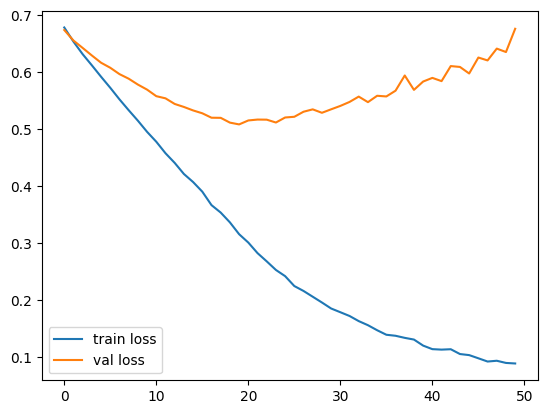

In [23]:
plt.plot([d["train_loss"] for d in train_metrics], label="train loss")
plt.plot([d["test_loss"] for d in val_metrics], label="val loss")
plt.legend()
plt.show()

## Save model prediction

Running this cell to save the model prediction to file `prediction.csv`, which you can download from the left hand side bar `Files` and submit it to your corresponding submit page for each group.

In [24]:
print("Saving Prediction to csv")
test_csv_path = "labeled_data/test/dataset_info.csv"
test_img_path = "labeled_data/test/img"
test_dataset_info = pd.read_csv(test_csv_path)
test_dataset = BasicAAADatasetWOLabel(test_img_path, test_dataset_info, num_classes)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
save_prediction(model, test_dataloader, test_dataset_info, class_labels)

Saving Prediction to csv


# Good Luck